<a href="https://colab.research.google.com/github/tigureis/Notes_and_exercises_on_Data_Structuring/blob/main/Gorupby_PivotTable_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html)

https://medium.com/analytics-vidhya/split-apply-combine-strategy-for-data-mining-4fd6e2a0cc99

In [43]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import scale, minmax_scale, power_transform
from IPython.core.display import HTML
import plotly.express as px

This code snippet utilizes the *Seaborn library* (`sns`) to customize the appearance of the plots in this project.

In [2]:
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    rc={
        'figure.figsize': (12,8)
    }
)

Load built-in example `'tips'` from `seaborn`

In [4]:
df = sns.load_dataset('tips')
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


# Aggregations

---



Group by one column and apply a function to all columns (where the function is applicable)

In [97]:
numerical_cols = df.select_dtypes(include='number').columns
df.groupby('sex',observed=False)[numerical_cols].mean().reset_index()

,sex,total_bill,tip,size
0,Male,20.744076,3.089618,2.630573
1,Female,18.056897,2.833448,2.459770


group by one column and apply a function to a target column, returning a `pandas.Series`

In [96]:
df.groupby('sex',observed=False)['tip'].mean().reset_index()

,sex,tip
0,Male,3.089618
1,Female,2.833448


Group by one column and apply a function to a target column returning a pandas.DataFrame (double "[[")

In [95]:
df.groupby('sex',observed=False)[['tip']].sum().reset_index()

,sex,tip
0,Male,485.07
1,Female,246.51


Group by multiple columns

In [94]:
df.groupby(['time','day'],observed=False)[['total_bill', 'tip']].mean().reset_index()

,time,day,total_bill,tip
0,Lunch,Thur,17.664754,2.767705
1,Lunch,Fri,12.845714,2.382857
2,Lunch,Sat,NaN,NaN
3,Lunch,Sun,NaN,NaN
4,Dinner,Thur,18.780000,3.000000
5,Dinner,Fri,19.663333,2.940000
6,Dinner,Sat,20.441379,2.993103
7,Dinner,Sun,21.410000,3.255132


Apply multiple aggregation functions supported by `pandas`

In [93]:
df.groupby('smoker',observed=False)[['tip']].agg(['min','max','mean','std']).reset_index()

smoker  tip                          
          min   max      mean       std
0    Yes  1.0  10.0  3.008710  1.401468
1     No  1.0   9.0  2.991854  1.377190

Apply simple custom functions together with functions supported by `pandas`

In [104]:
df.groupby('smoker',observed=False)[['tip']].agg(['min','max','mean','std', lambda x: x.mean()+10]).reset_index()

smoker  tip                                     
          min   max      mean       std <lambda_0>
0    Yes  1.0  10.0  3.008710  1.401468  13.008710
1     No  1.0   9.0  2.991854  1.377190  12.991854

Apply more complex custom functions

In [ ]:
def mean_diff(subdf):
  return np.mean( subdf['tip'] / subdf['total_bill'] )

df.groupby('sex',observed=False).apply(lambda x: str(round(mean_diff(x)*100, 2))+'%').reset_index()

<ipython-input-92-935c74a93956>:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,sex,0
0,Male,15.77%
1,Female,16.65%


# Transformation

Group-wise standardization

---

This code snippet takes all the tips given by males and standardizes them separately from the tips given by females. Standardization involves centering the data around zero by subtracting the mean and scaling it by dividing by the standard deviation. This ensures that the tips for males and females are comparable, even if their original distributions were different.

In [106]:
df.groupby('sex', observed=False)[['tip']].transform(scale)


,tip
0,-1.581740
1,-0.963126
2,0.276472
3,0.148470
4,0.673616
...,...
239,1.906813
240,-0.722970
241,-0.734070
242,-0.902493


Rolling Mean

---

This code snippet calculates a moving average of the 'tip' values for each gender (male or female) separately, considering 3 consecutive tips at a time to smooth out fluctuations and reveal trends within each group.

In [108]:
df.groupby('sex',observed=False)[['tip']].rolling(3).mean()

tip
sex                 
Male   1         NaN
       2         NaN
       3    2.823333
       5    3.840000
       6    3.340000
...              ...
Female 226  2.500000
       229  2.460000
       238  3.183333
       240  3.183333
       243  3.223333

[244 rows x 1 columns]

Example of the same information with groupby and plot

---

The` barplot` and `ploty` functions perform groupby implicitly, meaning they can be called to analyze the DataFrame without needing an explicit `groupby`

In [109]:
df.groupby(['sex','smoker'],observed=False).tip.sum()

sex     smoker
Male    Yes       183.07
        No        302.00
Female  Yes        96.74
        No        149.77
Name: tip, dtype: float64

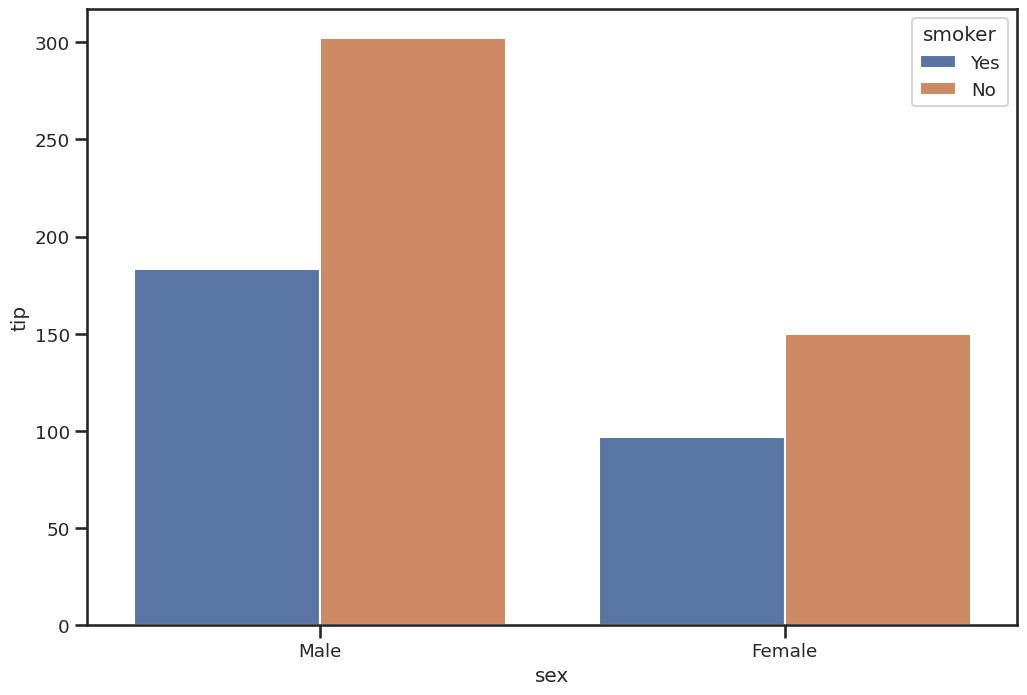

In [50]:
sns.barplot(data=df, x='sex', y='tip', hue='smoker',estimator=np.sum, errorbar=('ci', False));

In [45]:
px.bar(data_frame=df, x='sex', y='tip', color='smoker', barmode='group')

# [Pivot Table](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html)

---



Call `pivot_table` and compare it with `groupby`

In [89]:
df.pivot_table(index='sex',
               columns='day',
               values='tip',
               observed=False).reset_index()

day,sex,Thur,Fri,Sat,Sun
0,Male,2.980333,2.693000,3.083898,3.220345
1,Female,2.575625,2.781111,2.801786,3.367222


In [88]:
df.groupby(['sex','day'],observed=False)[['tip']].mean().reset_index()

,sex,day,tip
0,Male,Thur,2.980333
1,Male,Fri,2.693000
2,Male,Sat,3.083898
3,Male,Sun,3.220345
4,Female,Thur,2.575625
5,Female,Fri,2.781111
6,Female,Sat,2.801786
7,Female,Sun,3.367222


Call `pivot_table` with multiple *values*

In [87]:
df.pivot_table(index='sex',
               columns='time',
               values=['total_bill','tip'],
               aggfunc='sum',
               observed=False).reset_index()

sex    tip         total_bill         
time          Lunch  Dinner      Lunch   Dinner
0       Male  95.11  389.96     595.60  2661.22
1     Female  90.40  156.11     571.87   999.08

Call `pivot_table` with multiple *colums*

In [119]:
df.pivot_table(index='sex',
               columns=['time','day'],
               values=['total_bill','tip'],
               aggfunc=np.median,
               observed=False).reset_index()

<ipython-input-119-9d55cc338aef>:1: FutureWarning:

The provided callable <function median at 0x7df736224ca0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.



sex   tip                                 total_bill                \
time         Lunch       Dinner                         Lunch        Dinner   
day           Thur   Fri   Thur  Fri    Sat    Sun       Thur    Fri   Thur   
0       Male  2.53  1.92    NaN  3.0  3.000  3.085     16.975  12.16    NaN   
1     Female  2.00  2.75    3.0  3.0  2.625  3.500     13.420  14.70  18.78   

                            
time                        
day     Fri    Sat     Sun  
0     22.49  18.24  20.725  
1     15.38  18.36  17.410

Compare it with groupby

In [117]:
df.groupby(['sex','time','day'],observed=False)[['total_bill','tip']].median()

total_bill    tip
sex    time   day                    
Male   Lunch  Thur      16.975  2.530
              Fri       12.160  1.920
              Sat          NaN    NaN
              Sun          NaN    NaN
       Dinner Thur         NaN    NaN
              Fri       22.490  3.000
              Sat       18.240  3.000
              Sun       20.725  3.085
Female Lunch  Thur      13.420  2.000
              Fri       14.700  2.750
              Sat          NaN    NaN
              Sun          NaN    NaN
       Dinner Thur      18.780  3.000
              Fri       15.380  3.000
              Sat       18.360  2.625
              Sun       17.410  3.500

Call `pivot_table` with multiple *aggfunc*

In [82]:
df.pivot_table(
    index='sex',
    columns='time',
    values='tip',
    aggfunc=['median', np.std, lambda x: x.sum()],
    observed=False).reset_index()

<ipython-input-82-737871819ab5>:1: FutureWarning:

The provided callable <function std at 0x7df738ff16c0> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.



sex median              std           <lambda>        
time          Lunch Dinner     Lunch    Dinner    Lunch  Dinner
0       Male   2.31    3.0  1.329017  1.529116    95.11  389.96
1     Female   2.01    3.0  1.075108  1.193483    90.40  156.11

Call pivot_table with a dictionary

---

Notice that since values were specified in the *dictionary*, they don't need to be called within the function

In [81]:
agg_dict={'tip':'mean', 'total_bill':[np.median,'min']}
df.pivot_table(index='sex', columns='time', aggfunc=agg_dict, observed=False).reset_index()


<ipython-input-81-36f302bd84c5>:2: FutureWarning:

The provided callable <function median at 0x7df736224ca0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.



sex       tip           total_bill                    
                  mean               median          min       
time             Lunch    Dinner      Lunch Dinner Lunch Dinner
0       Male  2.882121  3.144839      16.58  19.63  7.51   7.25
1     Female  2.582857  3.002115      13.42  17.19  8.35   3.07

Wide and Long format

---

By selecting the 'day', 'time', and 'tip' columns, the table can be considered **long** because elements are repeated.

In [130]:
df.groupby(['day','time'],observed=False)['tip'].mean().reset_index()

,day,time,tip
0,Thur,Lunch,2.767705
1,Thur,Dinner,3.000000
2,Fri,Lunch,2.382857
3,Fri,Dinner,2.940000
4,Sat,Lunch,NaN
5,Sat,Dinner,2.993103
6,Sun,Lunch,NaN
7,Sun,Dinner,3.255132


By using `pivot_table`, the table would be in **wide** format, as elements are not repeated

In [77]:
df_pivot = df.pivot_table(index='day', columns='time', values='tip', observed=False).reset_index()
df_pivot

time,day,Lunch,Dinner
0,Thur,2.767705,3.000000
1,Fri,2.382857,2.940000
2,Sat,NaN,2.993103
3,Sun,NaN,3.255132


To revert to the **long** format, we can apply the `melt` function

In [123]:
df_pivot.melt(id_vars='day')

,day,time,value
0,Thur,Lunch,2.767705
1,Fri,Lunch,2.382857
2,Sat,Lunch,NaN
3,Sun,Lunch,NaN
4,Thur,Dinner,3.000000
5,Fri,Dinner,2.940000
6,Sat,Dinner,2.993103
7,Sun,Dinner,3.255132


With a table in **long** format, we can plot using `seaborn`or`plotly`

In [127]:
df_pivot.melt(id_vars='day') \
.plot.bar(backend='plotly', x='day', y='value', color='time', barmode='group')